# Dataset info

#### Name
Bitcoin OTC trust weighted signed network

#### Description
This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

#### Source
https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html
        
#### Data format
Each line has one rating, sorted by time, with the following format:

`SOURCE, TARGET, RATING, TIME`

where

- `SOURCE`: node id of source, i.e., rater
- `TARGET`: node id of target, i.e., ratee
- `RATING`: the source's rating for the target, ranging from -10 to +10 in steps of 1
- `TIME`: the time of the rating, measured as seconds since Epoch

# Exploratory analysis

## 1. Import libs

In [1]:
import pandas as pd
import seaborn as sb
from datetime import datetime
import matplotlib.pyplot as plt

## 2. Download dataset

***If you run the following cells it'll download and unzip the file in your working directory.***

In [2]:
!curl https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz --output soc-sign-bitcoinotc.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  387k  100  387k    0     0   152k      0  0:00:02  0:00:02 --:--:--  152k


In [3]:
!gzip -d soc-sign-bitcoinotc.csv.gz

In [4]:
!ls

reading_and_analyzing_the_dataset.ipynb soc-sign-bitcoinotc.csv


## 3,4. Read file and transform `time` column to datetime

In [5]:
df = (
    pd
    .read_csv('soc-sign-bitcoinotc.csv', names=['source', 'target', 'rating', 'time_epoch'])
    .assign(time=lambda df: df.time_epoch.apply(datetime.fromtimestamp))
)
df.head()

,source,target,rating,time_epoch,time
0,6,2,4,1.289242e+09,2010-11-08 19:45:11.728360
1,6,5,2,1.289242e+09,2010-11-08 19:45:41.533780
2,1,15,1,1.289243e+09,2010-11-08 20:05:40.390490
3,4,3,7,1.289245e+09,2010-11-08 20:41:17.369750
4,13,16,8,1.289254e+09,2010-11-08 23:10:54.447460


In [6]:
df.shape

(35592, 5)

## 5. Use the pandas function `describe`

In [7]:
df.describe()

,source,target,rating,time_epoch
count,35592.000000,35592.000000,35592.000000,3.559200e+04
mean,2353.847269,2417.478254,1.012025,1.355711e+09
std,1605.771178,1658.232170,3.562094,3.344739e+07
min,1.000000,1.000000,-10.000000,1.289242e+09
25%,988.000000,978.000000,1.000000,1.331243e+09
50%,2125.000000,2178.000000,1.000000,1.358385e+09
75%,3722.000000,3804.000000,2.000000,1.376599e+09
max,6000.000000,6005.000000,10.000000,1.453684e+09


- There doesn't seem to be any nulls
- `source` and `target`
    - There are some ids that are in `target` and not in `source`
    - Could be other way around as well
- `rating`
    - Can go from -10 to 10
    - Average (1.01) seems to be low compared to the range

## 6. Aggregate the ‘time’ column by weeks and plot the total row counts as a time series graph.

In [8]:
df.time.min(), df.time.max()

(Timestamp('2010-11-08 19:45:11.728360'),
 Timestamp('2016-01-25 02:12:03.757280'))

In [9]:
# label='left' means that the label used is the beginning (left) of the bin
# closed='left' means that the bin interval is closed on the beginning (left) of the interval
# chooshing only one column, in this case source, because all would give the same result
weekly_counts = df.resample('1W', on='time', label='left', closed='left')['source'].count()
weekly_counts.head()

time
2010-11-07    28
2010-11-14    12
2010-11-21    12
2010-11-28    11
2010-12-05    19
Freq: W-SUN, Name: source, dtype: int64

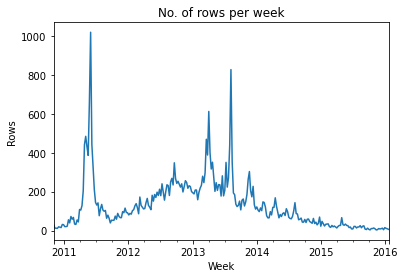

In [10]:
weekly_counts.plot()

plt.title('No. of rows per week')
plt.ylabel('Rows')
_=plt.xlabel('Week')

There are some spikes in number of rows in certain periods. Are these spikes in usage of the network as well? 

## 7. Aggregate the ‘time’ column by weeks and plot the average ratings as a time series graph.

In [11]:
weekly_avg_ratings = df.resample('1W', on='time', label='left', closed='left')['rating'].mean()
weekly_avg_ratings.head()

time
2010-11-07    5.035714
2010-11-14    2.500000
2010-11-21    2.083333
2010-11-28    3.272727
2010-12-05    1.263158
Freq: W-SUN, Name: rating, dtype: float64

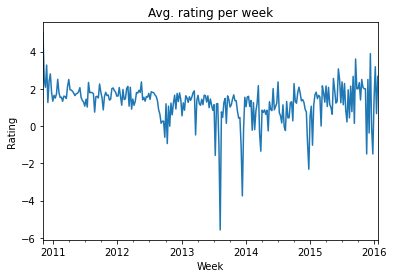

In [12]:
weekly_avg_ratings.plot()

plt.title('Avg. rating per week')
plt.ylabel('Rating')
_=plt.xlabel('Week')

Some of these valleys seem to match the spikes in no. of rows seen in the plot above

## 8. Plot the histogram of ratings

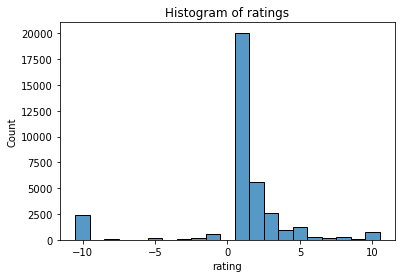

In [13]:
sb.histplot(df.rating, discrete=True)

_=plt.title('Histogram of ratings')

There seem to be a tendency towards either small values or the extremes (-10 and 10) with more positive than negative ratings overall

## 9. Plot the histogram of average ratings grouped by targeted users

In [14]:
avg_ratings_per_target = df.groupby('target')['rating'].mean()
avg_ratings_per_target.head()

target
1    3.544248
2    3.000000
3   -0.285714
4    3.111111
5    2.333333
Name: rating, dtype: float64

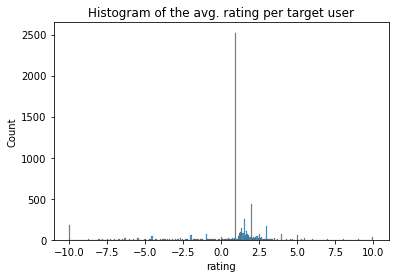

In [15]:
sb.histplot(avg_ratings_per_target)

_=plt.title('Histogram of the avg. rating per target user')

Too many bins but interesting to see a bit more of the pattern between 0 and 2.5-ish